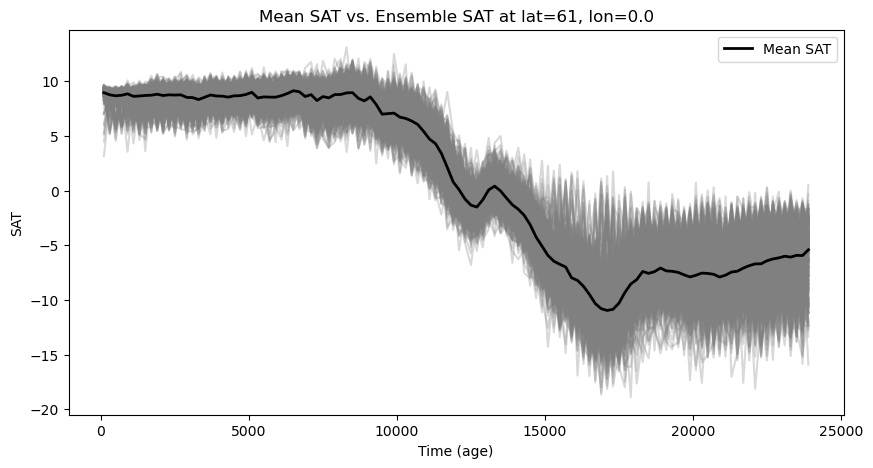

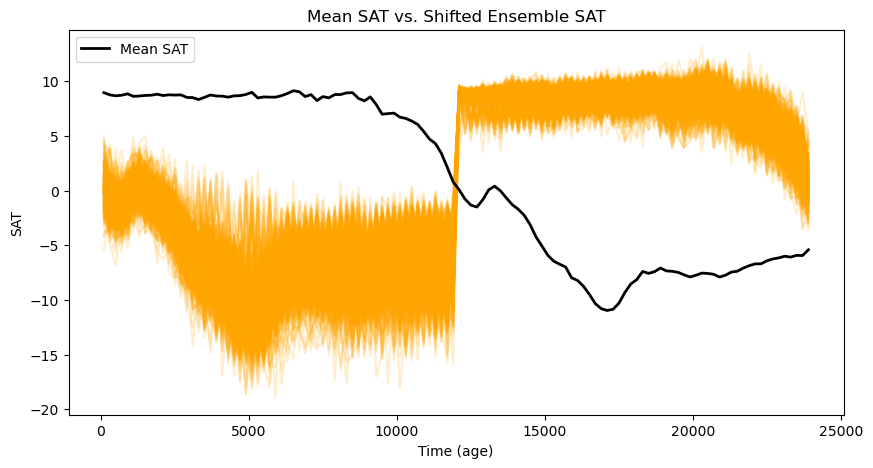

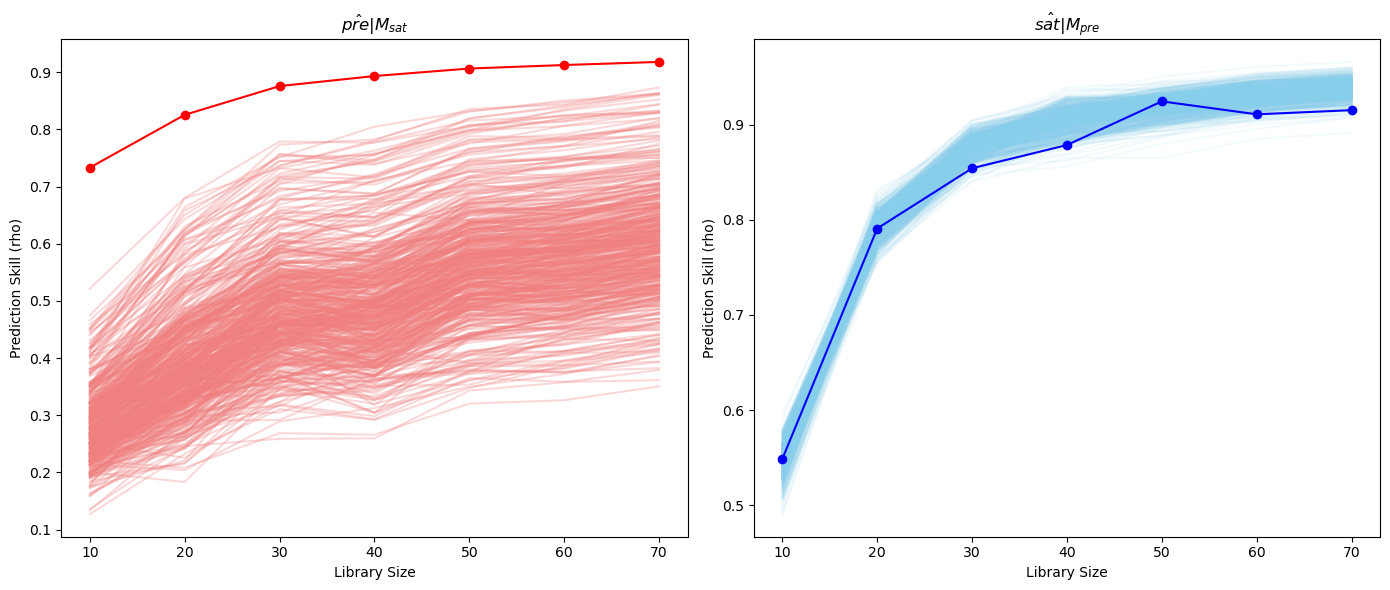

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyEDM import CCM

# ---------------------------
# Load data
# ---------------------------
ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
ds_sat_ens = xr.open_dataset('LGMR_data/LGMR_SAT_ens.nc')

# ---------------------------
# Select a grid point for testing
# ---------------------------
lat_idx = 80
lon_idx = 0
time = ds_sat['age'].values

# Mean SAT time series at the selected grid point
sat_mean = ds_sat['sat'].isel(lat=lat_idx, lon=lon_idx).values

# Ensemble SAT data at the same grid point (shape: nEns x time)
sat_ens = ds_sat_ens['sat'].isel(lat=lat_idx, lon=lon_idx).values

samples=100

# from sat_ens randomly select n samples



# ---------------------------
# 1. (Already plotted earlier) Plot mean SAT and ensemble members
# ---------------------------
plt.figure(figsize=(10, 5))
for i in range(sat_ens.shape[0]):
    plt.plot(time, sat_ens[i, :], color='gray', alpha=0.3)
plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
plt.xlabel("Time (age)")
plt.ylabel("SAT")
plt.title(f"Mean SAT vs. Ensemble SAT at lat={int(ds_sat['lat'].values[lat_idx])}, lon={ds_sat['lon'].values[lon_idx]}")
plt.legend()
plt.show()

# ---------------------------
# 2. Create shifted ensemble data
# ---------------------------
nTime = len(time)
half = nTime // 2
sat_ens_shifted = np.empty_like(sat_ens)
for i in range(sat_ens.shape[0]):
    ts = sat_ens[i, :]
    shifted_ts = np.concatenate((ts[half:], ts[:half]))
    sat_ens_shifted[i, :] = shifted_ts

plt.figure(figsize=(10, 5))
for i in range(sat_ens_shifted.shape[0]):
    plt.plot(time, sat_ens_shifted[i, :], color='orange', alpha=0.2)
plt.plot(time, sat_mean, color='k', lw=2, label='Mean SAT')
plt.xlabel("Time (age)")
plt.ylabel("SAT")
plt.title("Mean SAT vs. Shifted Ensemble SAT")
plt.legend()
plt.show()

# ---------------------------
# 3. Set CCM parameters and run CCM (one call returns both directions)
# ---------------------------
E_val = 4
tau_val = 3
Tp_val = 0
libSizes = "10 20 30 40 50 60 70"

# Prepare a common DataFrame for the mean SAT and pre data
df_ccm = pd.DataFrame({
    'Time': time,
    'X': sat_mean,
    'Y': df_pre['pre'].values
})
# Run CCM once: X is SAT and Y is pre. We assume the output DataFrame contains both "X:Y" and "Y:X"
ccm_out = CCM(
    dataFrame   = df_ccm,
    E           = E_val,
    tau         = tau_val,
    columns     = "X",   # SAT manifold
    target      = "Y",   # predict pre
    libSizes    = libSizes,
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = Tp_val
)

# For each ensemble member (shifted), compute CCM in the same way
ensemble_ccm = []
for i in range(sat_ens_shifted.shape[0]):
    df_temp = pd.DataFrame({
        'Time': time,
        'X': sat_ens_shifted[i, :],
        'Y': df_pre['pre'].values
    })
    try:
        out = CCM(
            dataFrame   = df_temp,
            E           = E_val,
            tau         = tau_val,
            columns     = "X",
            target      = "Y",
            libSizes    = libSizes,
            sample      = 10,
            random      = True,
            replacement = False,
            Tp          = Tp_val
        )
        ensemble_ccm.append(out)
    except Exception as e:
        print(f"Error in ensemble member {i}: {e}")

# ---------------------------
# 4. Plot the CCM curves in a subplot with two panels using the two output columns
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# --- Left subplot: SAT -> pre (use "X:Y") ---
ax = axes[0]
for i, out in enumerate(ensemble_ccm):
    label = 'Ensemble SAT CCM' if i == 0 else None
    ax.plot(out['LibSize'], out['X:Y'], color='lightcoral', linestyle='-', alpha=0.3, label=label)
ax.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Mean SAT CCM')
ax.set_xlabel("Library Size")
ax.set_ylabel("Prediction Skill (rho)")
ax.set_title(r'$\hat{pre}|M_{sat}$')
# ax.legend()

# --- Right subplot: pre -> SAT (use "Y:X") ---
ax2 = axes[1]
for i, out in enumerate(ensemble_ccm):
    label = 'Ensemble pre CCM' if i == 0 else None
    ax2.plot(out['LibSize'], out['Y:X'], color='skyblue', linestyle='-', alpha=0.1, label=label)
ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Mean pre CCM')
ax2.set_xlabel("Library Size")
ax2.set_ylabel("Prediction Skill (rho)")
ax2.set_title(r'$\hat{sat}|M_{pre}$')
# ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
def ccm_significance_test(ccm_mean, ensemble_ccm, if_plot=False):
    """
    Test whether the CCM result for the mean is significantly different from that of the shifted ensemble.
    
    Parameters:
      ccm_mean : pandas.DataFrame
          CCM output for the mean data. Must contain columns "LibSize", "X:Y", and "Y:X".
      ensemble_ccm : list of pandas.DataFrame
          A list of CCM outputs for each ensemble member, with the same columns as ccm_mean.
          
    Returns:
      bool: True if the CCM using SAT to predict pre is significantly different 
            (i.e. the mean value is outside the 5th-95th percentile of the ensemble) 
            AND the CCM using pre to predict SAT is not significant (i.e. the mean falls 
            within the ensemble range). Returns False otherwise.
    """
    # Use the maximum LibSize as the test point.
    max_lib = ccm_mean["LibSize"].max()
    
    # Extract mean values at the maximum LibSize.
    # mean_sat2pre = ccm_mean.loc[ccm_mean["LibSize"] == max_lib, "X:Y"].values[0]
    # mean_pre2sat = ccm_mean.loc[ccm_mean["LibSize"] == max_lib, "Y:X"].values[0]

    mean_sat2pre = np.mean(ccm_mean['X:Y'])
    mean_pre2sat = np.mean(ccm_mean['Y:X'])
    
    # Gather ensemble values at the maximum LibSize.
    ens_sat2pre = []
    ens_pre2sat = []
    for ens_df in ensemble_ccm:
        try:
            # val_sat2pre = ens_df.loc[ens_df["LibSize"] == max_lib, "X:Y"].values[0]
            # val_pre2sat = ens_df.loc[ens_df["LibSize"] == max_lib, "Y:X"].values[0]
            val_sat2pre = np.mean(ens_df['X:Y'])
            val_pre2sat = np.mean(ens_df['Y:X'])
            ens_sat2pre.append(val_sat2pre)
            ens_pre2sat.append(val_pre2sat)
        except Exception as e:
            print(f"Error extracting ensemble data: {e}")
    
    ens_sat2pre = np.array(ens_sat2pre)
    ens_pre2sat = np.array(ens_pre2sat)

    if if_plot:
        # plot the histogram of the ensemble values and a vertical line for the mean
        fig, axes = plt.subplots(1, 2, figsize=(12, 4),dpi=100)
        ax1 = axes[0]
        ax2 = axes[1]
        ax1.hist(ens_sat2pre, bins=20, density=True, color='lightcoral', alpha=0.5, label='Ensemble SAT->pre')
        ax1.axvline(mean_sat2pre, color='red', linestyle='--', label='Mean SAT->pre')
        ax1.set_title(r'$\hat{pre}|M_{sat}$')
        # add x-axis label
        ax1.set_xlabel("Prediction Skill (ρ)")
        ax1.set_ylabel("Frequency")
   

        # ax1.legend()
        ax2.hist(ens_pre2sat, bins=20, density=True, color='skyblue', alpha=0.5, label='Ensemble pre->SAT')
        ax2.axvline(mean_pre2sat, color='blue', linestyle='--', label='Mean pre->SAT')
        ax2.set_title(r'$\hat{sat}|M_{pre}$')
        # add x-axis label
        ax2.set_xlabel("Prediction Skill (ρ)")
        ax2.set_ylabel("Frequency")


        # ax2.legend()
        plt.show()
    
    # Compute the 5th and 95th percentiles of the ensemble distributions.
    lower_sat2pre = np.percentile(ens_sat2pre, 5)
    upper_sat2pre = np.percentile(ens_sat2pre, 95)
    lower_pre2sat = np.percentile(ens_pre2sat, 5)
    upper_pre2sat = np.percentile(ens_pre2sat, 95)
    
    # Condition 1: Mean SAT->pre prediction (X:Y) is outside the ensemble range.
    significant_sat2pre = (mean_sat2pre > upper_sat2pre) or (mean_sat2pre < lower_sat2pre)
    
    # Condition 2: Mean pre->SAT prediction (Y:X) is within the ensemble range.
    non_significant_pre2sat = (lower_pre2sat <= mean_pre2sat <= upper_pre2sat)
    
    return significant_sat2pre and non_significant_pre2sat

# Example usage:
# result = ccm_significance_test(ccm_out, ensemble_ccm)
# print("Significant (SAT significantly predicts pre, while pre does not predict SAT):", result)


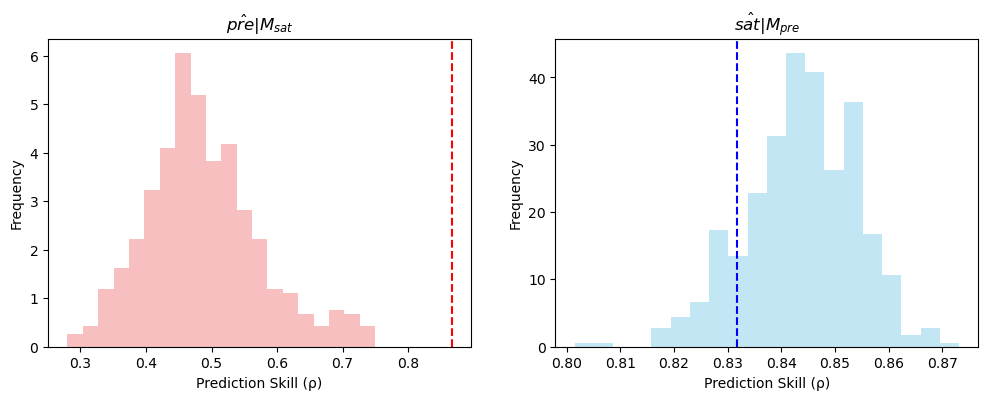

True

In [ ]:
result = ccm_significance_test(ccm_out, ensemble_ccm, if_plot=True)
result